### Recurrent Neural Network

Quick! complete the series A, B, C, D, E, F… That is easy right. Now try this Z, Y, X, W, V… Not that simple! How do we remember the same set of characters in a particular sequence and when the same set is to be recalled in a different way we struggle so hard. 

Such problems where the sequence or order of the events is really important for predicting the next event are usually tackled by Recurrent Neural Networks or RNN.

Recurrent Neural Networks (RNNs) are deep learning models, typically used to solve problems with sequential input data such as time series. What are they, and how do we use them in time series forecasting?


RNNs are a type of neural network that retains a memory of what it has already processed and thus can learn from previous iterations during its training.

How is a RNN different from a linear regression with many lags (an autoregressive model)? Turns out a RNN is not only a lot different but also more versatile and more powerful.

What exactly is a neural network trying to do? Like any other model, it’s trying to make a good prediction. We have a set of inputs and a set of target values — and we are trying to get predictions that match those target values as closely as possible.

A super simple neural network consists of just the following components:

1- A connection (though in practice, there will generally be multiple connections, each with its own weight, going into a particular neuron), with a weight “living inside it”, that transforms your input (using B1) and gives it to the neuron.
2- A neuron that includes a bias term (B0) and an activation function (sigmoid in our case).

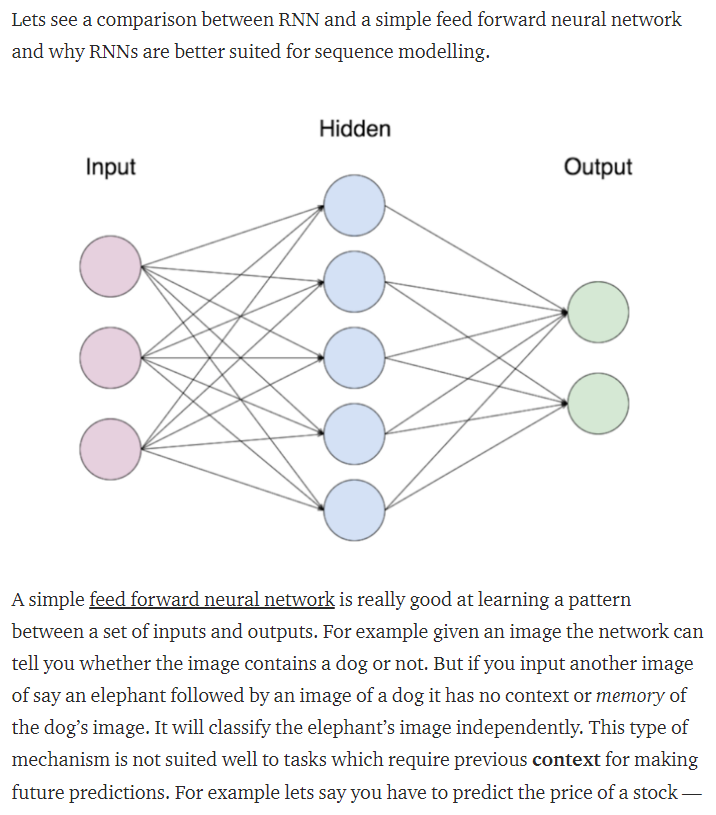

In [25]:
#Import all packages
from bisect import bisect_left
from IPython.display import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
from sklearn.decomposition import PCA
from ipywidgets import interact, FloatSlider

import timeit

import random
random.seed(10)

%matplotlib inline

Image(filename="Screenshot 2022-04-14 133315.png", width=600, height=800)


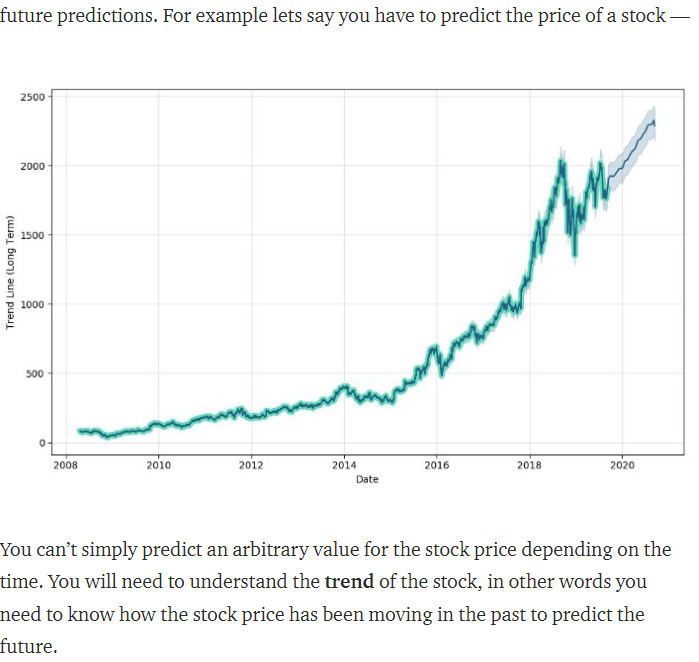

In [24]:
Image(filename="Screenshot 2022-04-14 133342.png", width=600, height=800)


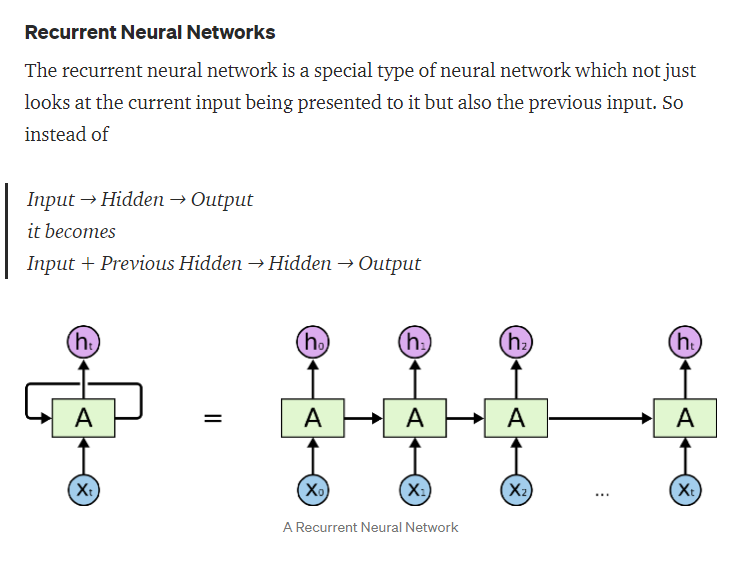

In [26]:
Image(filename="RNN.png", width=600, height=800)


Artificial neural networks (ANNs), usually simply called neural networks (NNs), are computing systems inspired by the biological neural networks that constitute animal brains.

An ANN is based on a collection of connected units or nodes called artificial neurons, which loosely model the neurons in a biological brain. Each connection, like the synapses in a biological brain, can transmit a signal to other neurons. An artificial neuron receives a signal then processes it and can signal neurons connected to it. The "signal" at a connection is a real number, and the output of each neuron is computed by some non-linear function of the sum of its inputs.

The training process of a neural network, at a high level, is like that of many other data science models — define a cost function and use gradient descent optimization to minimize it.

A recurrent neural network, by contrast, retains a memory of what it has processed in its recent previous steps 

It makes recurrent connections by going through temporal feedback loops: the output of a preceding step is used as an input for the current process step. 

The hidden layers are located between the input and the output layer. In an RNN, they not only produce an output, but they also feed it back (“backpropagate” it) as an input for training the hidden layer on the next observation

#### If the RNN deals with time series, each period will be represented by a node, holding the period’s observational value.

An input value, when it is passed from its node on one layer to a node in another layer, travels along an edge (the connecting line) between the nodes. The edges are comparable to a brain’s synapses.

The receiving node sums all the inputs it receives to a total net input.

It feeds this net input into an activation function (aka transfer function) to compute the output: how much the node will contribute to the next layer.

The activation function’s output value is multiplied by a weight factor when it is sent out along an edge to a node in another layer, or over multiple edges to more than one receiving node.

The calibration mechanism a recurrent neural network applies is described by two terms you will encounter in most RNN descriptions:

backpropagation through time (BPTT) aka temporal loops;
and gradient descent.

When the network generates prediction values, it also computes the prediction error, the deviation from the training dataset. The network seeks to minimize the error by adjusting its internal weights during training. Backpropagation calculates the partial derivatives of the error with respect to the weights. Then the RNN recalibrates the weights, up or down, based on the partial derivatives.


For training our neural network, we will use Mean Squared Error (MSE) as the cost function:
MSE = Sum [ ( Prediction - Actual )² ] * (1 / num_observations)

The cost function (aka loss, error, or objective function) measures the prediction error of the network as a number, a scalar. The goal of the RNN is to minimize the cost function. Prediction accuracy metrics such as the mean squared error MSE or root mean squared error RMSE, which we know from other time series methods, can serve as cost functions


Then the RNN investigates how the total error is spread out over all the weights in the network. It finds their individual contributions to the total error by calculating partial derivatives, aka gradients (‘slopes’). The loss function includes a multitude of weights. The partial derivative with respect to a certain weight reveals how that particular weight affects the total error.

In [1]:
pip install Keras


Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install tensorflow

  Created wheel for termcolor: filename=termcolor-1.1.0-py3-none-any.whl size=4829 sha256=f2aae95c4038a21bba348f1246d5d5c6668e0bb33759763813357b30b59b9c25
  Stored in directory: c:\users\sn3028\appdata\local\pip\cache\wheels\a0\16\9c\5473df82468f958445479c59e784896fa24f4a5fc024b0f501
Successfully built termcolor
  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 3.10.0
    Uninstalling importlib-metadata-3.10.0:
      Successfully uninstalled importlib-metadata-3.10.0
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

In [4]:
df = pd.read_csv('https://github.com/sahilnisar/.ipynb_checkpoints/raw/main/US_Forecasting_Data_1972_2021.csv', error_bad_lines=False)
df=df[['dlog_gdp_yoy']].iloc[4:,]
df

,dlog_gdp_yoy
4,0.031658
5,0.026614
6,0.020241
7,0.017133
8,0.002765
...,...
195,-0.009941
196,0.002369
197,0.050096
198,0.020968


In [6]:
values=df.values
train,test = values[:180,:], values[180:,:]

In [9]:
step=4
test = np.append(test,np.repeat(test[-1,],step))
train = np.append(train,np.repeat(train[-1,],step))

In [10]:
# convert into dataset matrix
def convertToMatrix(df, step):
 X, Y =[], []
 for i in range(len(df)-step):
  d=i+step  
  X.append(df[i:d,])
  Y.append(df[d,])
 return np.array(X), np.array(Y)

trainX,trainY =convertToMatrix(train,step)
testX,testY =convertToMatrix(test,step)

In [11]:
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
trainX.shape

(180, 1, 4)

In [12]:
# SimpleRNN model
model = Sequential()
model.add(SimpleRNN(units=16, input_shape=(1,step), activation="relu"))
model.add(Dense(8, activation="relu")) 
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='rmsprop')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 16)                336       
                                                                 
 dense (Dense)               (None, 8)                 136       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 481
Trainable params: 481
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.fit(trainX,trainY, epochs=100, batch_size=16, verbose=2)
trainPredict = model.predict(trainX)
testPredict= model.predict(testX)
predicted=np.concatenate((trainPredict,testPredict),axis=0)

Epoch 1/100
12/12 - 1s - loss: 9.5331e-05 - 667ms/epoch - 56ms/step
Epoch 2/100
12/12 - 0s - loss: 5.9315e-05 - 8ms/epoch - 665us/step
Epoch 3/100
12/12 - 0s - loss: 5.5932e-05 - 8ms/epoch - 665us/step
Epoch 4/100
12/12 - 0s - loss: 4.3270e-05 - 8ms/epoch - 665us/step
Epoch 5/100
12/12 - 0s - loss: 3.6565e-05 - 10ms/epoch - 829us/step
Epoch 6/100
12/12 - 0s - loss: 3.6762e-05 - 8ms/epoch - 665us/step
Epoch 7/100
12/12 - 0s - loss: 3.3644e-05 - 9ms/epoch - 748us/step
Epoch 8/100
12/12 - 0s - loss: 2.6939e-05 - 7ms/epoch - 582us/step
Epoch 9/100
12/12 - 0s - loss: 2.8111e-05 - 11ms/epoch - 914us/step
Epoch 10/100
12/12 - 0s - loss: 2.4464e-05 - 8ms/epoch - 665us/step
Epoch 11/100
12/12 - 0s - loss: 2.9514e-05 - 8ms/epoch - 665us/step
Epoch 12/100
12/12 - 0s - loss: 3.0118e-05 - 10ms/epoch - 831us/step
Epoch 13/100
12/12 - 0s - loss: 2.4282e-05 - 8ms/epoch - 665us/step
Epoch 14/100
12/12 - 0s - loss: 3.0947e-05 - 10ms/epoch - 833us/step
Epoch 15/100
12/12 - 0s - loss: 2.3249e-05 - 9ms/epo

In [14]:
trainScore = model.evaluate(trainX, trainY, verbose=0)
print(trainScore)

1.5185465599643067e-05


In [103]:
date = pd.read_csv('https://github.com/sahilnisar/.ipynb_checkpoints/raw/main/US_Forecasting_Data_1972_2021.csv', error_bad_lines=False)
date=date[['date', 'dlog_gdp_yoy']].iloc[4:,]
date=date.set_index('date')
date=date.index.values

<AxesSubplot:xlabel='Years', ylabel='Log GDP'>

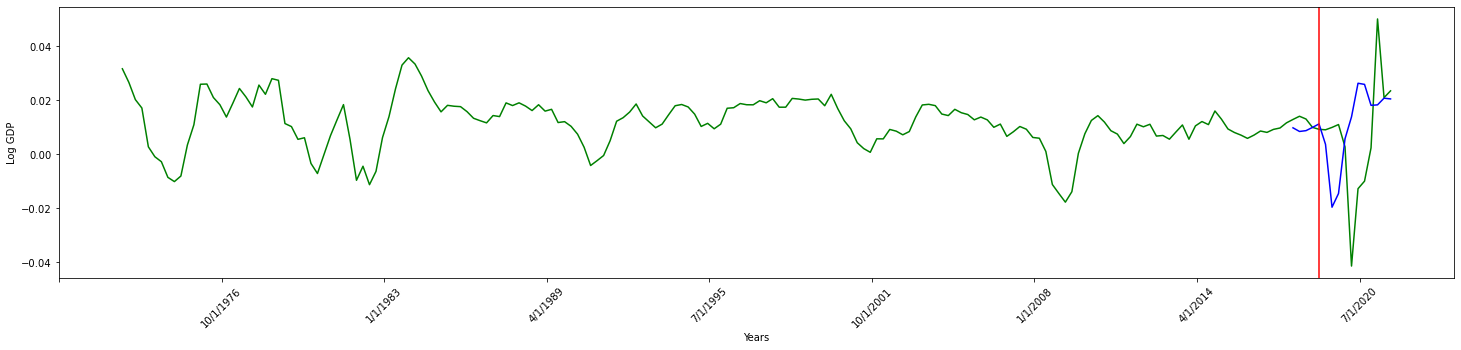

In [119]:
fig, ax=plt.subplots()
plt.rcParams['figure.figsize'] = (22,5)
ax.plot(date,df, c="g")
ax.plot(d,p,  c="b")
start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 25))
plt.xticks(rotation=45)
ax.axvline(df.index[180], c="r")
ax.set_ylabel('Log GDP')
ax.set_xlabel('Years')
ax

In [94]:
p=predicted[180:]

In [99]:
d=date[180:]